In [2]:
#!pip install pyspellchecker
#!pip install wordcloud

#  Sentiment Analysis of Product Reviews

- In this file we will create models to predict sentiment of reviews
- Approach taken :
     - use only necessary columns for creating models
     - Text Preprocessing on review text like : remove urls, make reviews in the same case, remove words which have maximum frquency in both sentiments, Tokenize words,Correct the spelling of words
     - Split data into train-test
     - Create word embedding using : "TF-IDF" and " Word2Vec"
     - Handle class imbalance using SMOTE
     - Then on this dataset  create Logistic, XGBoost, Naive bayes model
     - Compare which model and which embedding is good and use that model for final reviews
     - Do the hyperparameter tuning on Final selected model to impeove accuracy
     - Use this model for sentiment prediction
     

In [4]:
import pandas as pd
import pandas_profiling as pp
import numpy as np
import  matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [5]:
df= pd.read_csv("sample30.csv", delimiter=",")

In [6]:
# Generating report to get understanding of data 
#report = pp.ProfileReport(df,title="Sentiment Analysis",html={'style':{'full_width': True}})

In [7]:
#report.to_widgets() #to_widget is not working correctlt in colab

In [8]:
#report.to_notebook_iframe()

In [9]:
print("shape of data is : ",df.shape)

shape of data is :  (30000, 15)


In [10]:
df.nunique()

id                        271
brand                     214
categories                270
manufacturer              227
name                      271
reviews_date             6857
reviews_didPurchase         2
reviews_doRecommend         2
reviews_rating              5
reviews_text            27282
reviews_title           18535
reviews_userCity          977
reviews_userProvince       42
reviews_username        24914
user_sentiment              2
dtype: int64

we have 271 products having unique names and ID as count is excat 271 for both

In [11]:
#Let's check for null values
df.isnull().sum()

id                          0
brand                       0
categories                  0
manufacturer              141
name                        0
reviews_date               46
reviews_didPurchase     14068
reviews_doRecommend      2570
reviews_rating              0
reviews_text                0
reviews_title             190
reviews_userCity        28071
reviews_userProvince    29830
reviews_username           63
user_sentiment              1
dtype: int64

In [12]:
#create new category for null reviews_didPurchase null values
df['reviews_didPurchase'].fillna("Missing didPurchase",inplace=True)

Text(0.5, 1.0, 'True vs fake reviews')

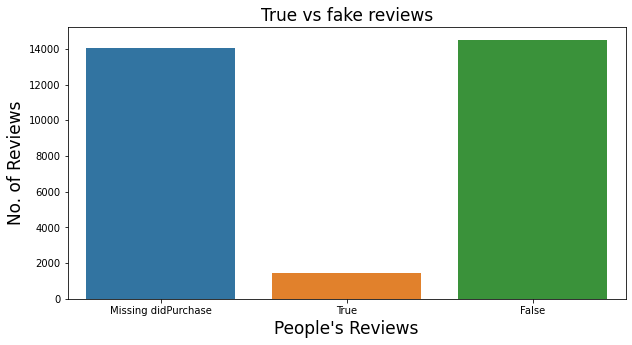

In [13]:
plt.figure(figsize=(10,5))
ax=sns.countplot(df['reviews_didPurchase'])
ax.set_xlabel(xlabel="People's Reviews",fontsize=17)
ax.set_ylabel(ylabel='No. of Reviews',fontsize=17)
ax.axes.set_title('True vs fake reviews',fontsize=17)

- We can see there are many reviews which we can say are fake means people have giveb reviews but not purchased product
- Genuine reviews are less
- also for many products purchase information is null

In [14]:
# as ID ,name and brand makes one unique product we will create one sep[arate dataframe of it

# Df having Unique Product name-brand with ID

In [15]:
# Create file with unique ID name and brand of product
UniqueProdcutNameDf = (df[["id","brand","name"]].drop_duplicates()).reset_index(drop=True)
# we will create new productname by concating name and brand of product using 'by'
UniqueProdcutNameDf["name_by_brand"] = UniqueProdcutNameDf["name"] + " by " + UniqueProdcutNameDf["brand"]
#lets delete original columns
UniqueProdcutNameDf.drop(["name","brand"],axis=1,inplace= True)
print("shape of newly created  product ID,name,brand dataframe is : ",UniqueProdcutNameDf.shape)
#Save file
UniqueProdcutNameDf.to_csv(".csv")
#Check first 5 records

UniqueProdcutNameDf.head()

UniqueProdcutNameDf.to_csv('id_name.csv', index=False)

shape of newly created  product ID,name,brand dataframe is :  (271, 2)


#Creating df for sentiment Analysis

- For sentiment analysis we will use only 3 columns : reviews_text ,reviews_title , user_sentiment

In [16]:
sentiment_df = df[['reviews_text', 'reviews_title', 'user_sentiment']]

In [17]:
sentiment_df.isnull().sum()

reviews_text        0
reviews_title     190
user_sentiment      1
dtype: int64

In [18]:

#Create new column by appending title and review of product
sentiment_df['reviews'] = sentiment_df['reviews_title'].fillna(" ") + " " + sentiment_df['reviews_text'] 
# trim empty spaces before and after the string
sentiment_df['reviews'] = sentiment_df['reviews'].str.strip()
#Create new column length of review text 
sentiment_df['reviews_length'] = sentiment_df['reviews_text'].apply(len)
#DROP originaltexr and title columns
sentiment_df.drop(['reviews_text', 'reviews_title'],axis=1,inplace=True)

In [19]:
sentiment_df.isnull().sum()

user_sentiment    1
reviews           0
reviews_length    0
dtype: int64

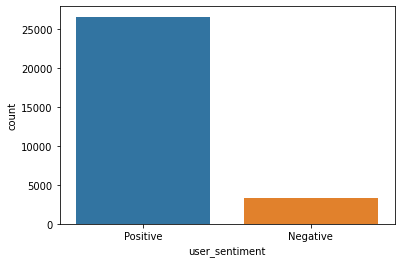

Positive    0.887763
Negative    0.112237
Name: user_sentiment, dtype: float64

In [20]:
#Checking percentage of classes for positive and negative
sns.countplot(sentiment_df["user_sentiment"])
plt.show()
#Percentage of values
sentiment_df["user_sentiment"].value_counts(normalize=True)

- We can say that we have more positive reviews and less negative.
- So we need to handle class imbalance while creating model

In [21]:
#We have created new column of length of reviews
sentiment_df["reviews_length"].describe()

count    30000.000000
mean       183.056967
std        186.054147
min          2.000000
25%         83.000000
50%        131.000000
75%        217.000000
max       5865.000000
Name: reviews_length, dtype: float64

- we have min 2 words in review and max is 5865 words review
- We will truncate the length of much long reviews later

In [22]:
# Lets map our target variable with 0: negative review and 1 for positive review
sentiment_df["user_sentiment"] = sentiment_df["user_sentiment"].map({"Positive":1,"Negative":0})

In [23]:
sentiment_df.head()

,user_sentiment,reviews,reviews_length
0,1.0,Just Awesome i love this album. it's very good...,201
1,1.0,Good Good flavor. This review was collected as...,62
2,1.0,Good Good flavor.,12
3,0.0,Disappointed I read through the reviews on her...,696
4,0.0,Irritation My husband bought this gel for us. ...,132


In [24]:
#checking null value count
print(" dataset shape before removing rows : ",sentiment_df.shape)
sentiment_df.isnull().sum()

 dataset shape before removing rows :  (30000, 3)


user_sentiment    1
reviews           0
reviews_length    0
dtype: int64

In [25]:
# WE will remove null values for reviews and also sentiment as those are very less
sentiment_df.dropna( subset=['user_sentiment'], inplace=True)
print(" dataset shape after removing rows : ",sentiment_df.shape)

 dataset shape after removing rows :  (29999, 3)


count    29999.000000
mean       183.050768
std        186.054151
min          2.000000
50%        131.000000
90%        359.000000
95%        489.000000
99%        883.000000
99.5%     1116.000000
99.7%     1333.006000
max       5865.000000
Name: reviews_length, dtype: float64

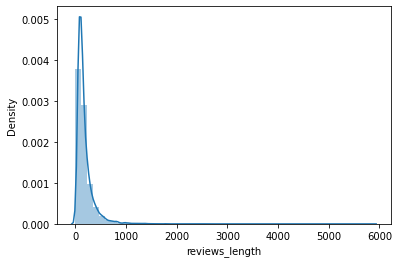

In [26]:
sns.distplot(sentiment_df["reviews_length"])
sentiment_df["reviews_length"].describe(percentiles=[0.997,0.995,0.99,0.95,0.90])

- We can see distribution is much skewed
- 99.7% of data is having length less than or equal to 1333
- So we will keep the reviews having length of 1000 or less

In [27]:
 sentiment_df= sentiment_df[ sentiment_df["reviews"].str.len()<=1000]
 sentiment_df.shape

(29752, 3)

- we were having 246 reviews having length greater than 1000 which.
- after dropping those reviews we have 29563 records.
- lets plot the length of reviews again.

<AxesSubplot:xlabel='reviews_length', ylabel='Density'>

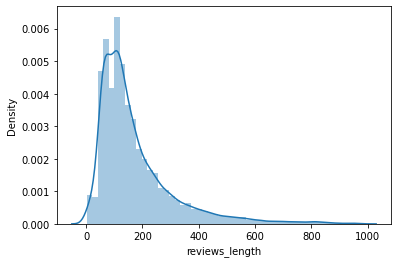

In [28]:
sns.distplot(sentiment_df["reviews_length"])

- graph is still right skewed but its less than earlier now.

# Text preprocessing

In [29]:
#make all the reviews in samll case
sentiment_df["reviews"] = sentiment_df["reviews"].str.lower()

In [30]:
#Remove urls from reviews using regex
sentiment_df["reviews"] = sentiment_df["reviews"].str.replace('http\S+|www.\S+', '', case=False)

In [31]:
#Remove special characters and numbers from review
sentiment_df["reviews"] = sentiment_df["reviews"].str.replace('[^a-zA-Z ]+', '',)

In [32]:
# remove the words having length less than or equal to 2
sentiment_df['reviews'] = sentiment_df['reviews'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

In [33]:
#nltk.download('punkt')
#nltk.download('stopwords')

In [34]:
# Tokensize sentences into words
from nltk.tokenize import word_tokenize
sentiment_df['reviews'] = sentiment_df['reviews'].apply(lambda x: word_tokenize(x))

In [35]:
#Remove stopwords
from nltk.corpus import stopwords


In [36]:
sentiment_df['reviews'] = sentiment_df['reviews'].apply(lambda x : [w for w in x if w not in stopwords.words('english')])

In [37]:
#Lets normalize the words using Stemming
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()
sentiment_df['reviews'] = sentiment_df['reviews'].apply(lambda x: [stemmer.stem(i) for i in x]) 

- AS using stemming changes the spelling of word also there are spelling mistakes so we will use library to correct spelling of word

In [38]:
import timeit
from spellchecker import SpellChecker

In [39]:
spell = SpellChecker()
#Apply spellchecker to every word
sentiment_df['reviews'] = sentiment_df['reviews'].apply(lambda x: [spell.correction(i) for i in x])

In [40]:
#Now we will join alltokens
sentiment_df['reviews'] = sentiment_df['reviews'].apply(lambda x : " ".join(x))

In [41]:
# Clean df
sentiment_df.to_csv("Clean_sentiment_df_new.csv")

In [42]:
#df_senti_clean = pd.read_csv("/content/Clean_sentiment_df_new.csv")
#df_senti_clea.drop("Unnamed: 0",inplace=True,axis=1)

In [43]:
#df_senti_clea.info()

# Most Commonly used word using WordCloud
- Word Cloud is a data visualization technique used for representing text data in which the size of each word indicates its frequency or importance.

In [44]:
#!pip install wordcloud

In [45]:
positive_sentiment_text = ' '.join([text for text in sentiment_df[sentiment_df['user_sentiment'] == 1.0] ["reviews"]])

In [46]:

negative_sentiment_text = ' '.join([text for text in sentiment_df[sentiment_df['user_sentiment'] == 0.0] ["reviews"]])
alltext = ' '.join([text for text in sentiment_df["reviews"]])

In [47]:
from wordcloud import WordCloud, STOPWORDS
comment_words = ''
stopwords = set(STOPWORDS)
wordcloud_positive = WordCloud(width = 800, height = 800,
                background_color ='black',
                stopwords = stopwords,
                min_font_size = 10).generate(positive_sentiment_text)

wordcloud_negative = WordCloud(width = 800, height = 800,
                background_color ='black',
                stopwords = stopwords,
                min_font_size = 10).generate(negative_sentiment_text)


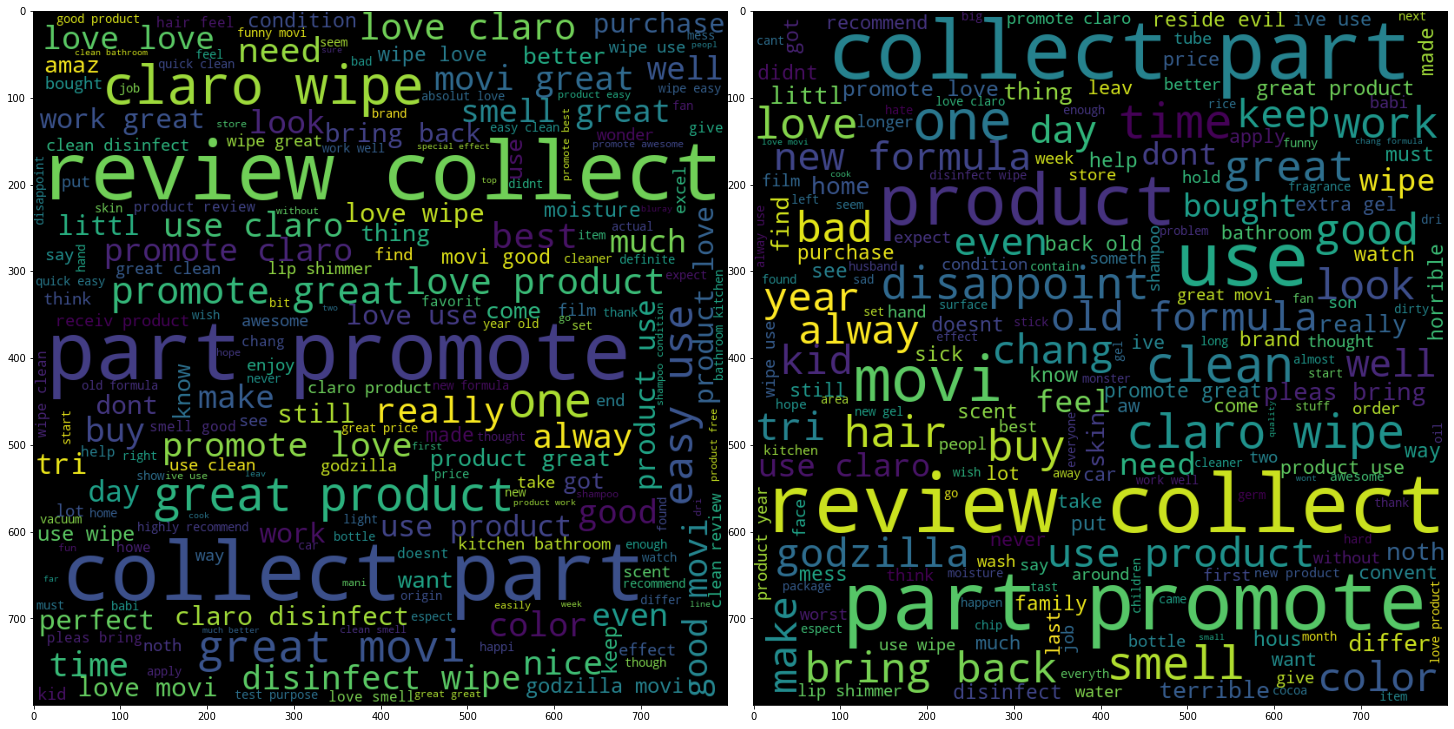

In [48]:
# Python program to generate WordCloud
  
 
# plot the WordCloud image                       
plt.figure(figsize = (20, 10), facecolor = None)
ax1 = plt.subplot(1,2,1)
ax1.imshow(wordcloud_positive)
ax2 = plt.subplot(1,2,2)
ax2.imshow(wordcloud_negative)
#plt.axis("off")
plt.tight_layout(pad = 0)
  

- We can see in both positive and negative sentiments most occuring words are : review, collect,part,promote,product
- We will remove these words as they are common in both and frquency is much high

In [49]:
wordstoRemove =["review", "collect","part","promote","product","really"]

In [50]:
sentiment_df["reviews"] = sentiment_df["reviews"].apply(lambda x : " ".join([w for w in x.split() if w not in wordstoRemove]) )

# Train Test Split
- We will devide data in 80:20 split

In [51]:
from sklearn.model_selection import train_test_split

In [52]:
y= sentiment_df.pop("user_sentiment")
X= sentiment_df

In [53]:
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.8,random_state=42)

print("X train size is : ", X_train.shape)
print("X test size is  : ", X_test.shape)
print("y train size is : ", y_train.shape)
print("y test size is  : ", y_test.shape)

X train size is :  (23801, 2)
X test size is  :  (5951, 2)
y train size is :  (23801,)
y test size is  :  (5951,)


# Check for imbalance of classes

In [54]:
print(" Class distriibution is Train set : ",y_train.value_counts(normalize=True))

print(" Class distriibution is Test set : ",y_test.value_counts(normalize=True))

 Class distriibution is Train set :  1.0    0.887736
0.0    0.112264
Name: user_sentiment, dtype: float64
 Class distriibution is Test set :  1.0    0.885397
0.0    0.114603
Name: user_sentiment, dtype: float64


In [55]:
X_train.head()

,reviews,reviews_length
5599,slow would buy sequel way slow riding bad,63
16975,five star rice tast great,16
27029,love bought ad love jason great sing voice lis...,99
18281,ye year old daughter love did,37
431,cream need person use makeup wash face apply r...,318


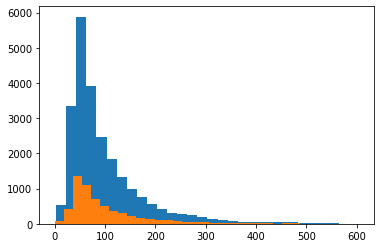

In [56]:
#lets check the distribution of length of reviews in train and test dataset
plt.hist(X_train["reviews"].str.len(),bins=30)
plt.hist(X_test["reviews"].str.len(),bins=30)
plt.show()

In [57]:
X_train.drop("reviews_length",axis=1,inplace=True)
X_test.drop("reviews_length",axis=1,inplace=True)


In [58]:
X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)

In [59]:
X_train.head()

,reviews
0,slow would buy sequel way slow riding bad
1,five star rice tast great
2,love bought ad love jason great sing voice lis...
3,ye year old daughter love did
4,cream need person use makeup wash face apply r...


# Feature Extraction : TF-IDF

In [60]:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

In [61]:

#tfidf object with max feature 
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

#Train
tfidf_train = tfidf_vectorizer.fit_transform(X_train["reviews"])
print("TFIDF Vaector size for TRAIN ain data : ", tfidf_train.shape)

#Test
tfidf_test= tfidf_vectorizer.transform(X_test["reviews"])
print("TFIDF Vaector size for TEST rain data : ", tfidf_test.shape)

TFIDF Vaector size for TRAIN ain data :  (23801, 5000)
TFIDF Vaector size for TEST rain data :  (5951, 5000)


In [62]:
import pickle

# Save to file in the current working directory
pkl_filename = "tf_idf_vectorizer_new.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(tfidf_vectorizer, file)

In [63]:
tfidf_train = pd.DataFrame(tfidf_train.toarray())
tfidf_test  = pd.DataFrame(tfidf_test.toarray())
tfidf_train.shape

(23801, 5000)

In [64]:
tfidf_test.head()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Feature Extraction : Word2vec

In [65]:
#pip install gensim

In [66]:

from gensim.models import Word2Vec

In [67]:
tokenized_reviews_train = X_train['reviews'].apply(lambda x: x.split())

In [68]:
model_word2Vec = Word2Vec(tokenized_reviews_train,sg=1, min_count=4, seed=42, vector_size=200)

In [69]:
#above line gives error for size use below line and comment above line and vice versa
#model_word2Vec = Word2Vec(tokenized_reviews_train,sg=1, min_count=4, seed=42, size=200)

In [70]:
# Save model in Binary fromat
model_word2Vec.wv.save_word2vec_format('model_word2Vec_new.bin')


In [71]:
# Predict next word given a word using earlier created Word2vec vwctor model
from gensim.models import KeyedVectors

word_model = KeyedVectors.load_word2vec_format('model_word2Vec_new.bin')

In [72]:
#We will use the below function to create a vector for each review 
#by taking the average of the vectors of the words present in the review.
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        if word in word_model.key_to_index:
            vec += word_model[word].reshape((1, size))
            count += 1    
    if count != 0:
        vec /= count
    return vec

#### If below line gives error related to model.wv.vocab then in the above function word_vector()
- Replace this line : if word in word_model.wv.vocab:
- with if word in word_model.key_to_index :

In [73]:
wordvec_arrays = np.zeros((len(tokenized_reviews_train), 200))

for i in range(len(tokenized_reviews_train)):
    wordvec_arrays[i,:] = word_vector(tokenized_reviews_train[i], 200)
    
train_word2vec = pd.DataFrame(wordvec_arrays)
train_word2vec.shape

(23801, 200)

- We have 200 features for word2Vec model
- 5000 features for tf-idf model


In [74]:
train_word2vec.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.161899,0.220116,0.128200,-0.114458,0.162597,0.024014,0.179945,0.132413,-0.120385,0.038403,...,-0.226894,0.095914,0.124271,-0.142763,0.081840,-0.275289,-0.039372,0.081731,0.039277,-0.037021
1,0.261958,0.086692,0.094015,0.100767,0.083876,-0.066420,0.067930,0.047651,-0.040343,0.013853,...,-0.327293,0.029451,-0.019663,-0.281756,0.015834,-0.302633,0.067482,0.369061,0.002781,0.195872
2,0.145426,0.178627,0.110488,0.174033,0.131882,0.023683,0.067001,0.150104,-0.113306,0.000540,...,-0.211818,-0.043291,0.040190,-0.112786,0.044416,-0.288182,0.081412,-0.047485,-0.128118,0.086591
3,0.082020,0.213178,0.106407,0.153510,0.135232,-0.010406,0.029267,0.269881,-0.121540,-0.105725,...,-0.201581,-0.146289,0.080021,-0.110088,-0.013469,-0.323298,0.040883,-0.116031,-0.073137,0.042784
4,0.075541,-0.105484,0.072149,0.160758,0.148860,-0.008045,0.154208,0.129693,-0.009257,-0.021265,...,-0.036021,-0.015286,-0.083280,-0.294755,0.157427,-0.173661,0.152526,-0.034688,0.186365,-0.160653


In [75]:
#making  word embeding for test words
tokenized_reviews_test = X_test['reviews'].apply(lambda x: x.split())
wordvec_arrays = np.zeros((len(tokenized_reviews_test), 200))

for i in range(len(tokenized_reviews_test)):
    wordvec_arrays[i,:] = word_vector(tokenized_reviews_test[i], 200)
    
test_word2vec = pd.DataFrame(wordvec_arrays)
print("Shape of Test data  Word2vec features :", test_word2vec.shape)

Shape of Test data  Word2vec features : (5951, 200)


# Handle class imbalance using SMOTE

In [76]:
#Check values of labels in y_train and y_tes
from collections import Counter
print("Label % for Train Dataset :\n", )
y_train.value_counts(normalize=True)

Label % for Train Dataset :



1.0    0.887736
0.0    0.112264
Name: user_sentiment, dtype: float64

In [77]:
print("Label % for Train Dataset :\n", )
y_test.value_counts(normalize=True)

Label % for Train Dataset :



1.0    0.885397
0.0    0.114603
Name: user_sentiment, dtype: float64

In [78]:
from imblearn.over_sampling import SMOTE

In [79]:
oversample = SMOTE(random_state=26)

X_train_tfidf, y_train_tfidf = oversample.fit_resample(tfidf_train, y_train)
X_train_word2vec, y_train_word2vec = oversample.fit_resample(train_word2vec, y_train)

In [80]:
#Lets chack the valuecount
print("After resampling count of labels for tf-idf model")
from collections import Counter
print(Counter(y_train_tfidf))

#Lets chack the valuecount
print("\n After resampling count of labels for word2Vec model")
from collections import Counter
Counter(y_train_word2vec)

After resampling count of labels for tf-idf model
Counter({0.0: 21129, 1.0: 21129})

 After resampling count of labels for word2Vec model


Counter({0.0: 21129, 1.0: 21129})

# Model Building

##  1. Logistic Regression

In [81]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score

#### Logistic regression using TF-IDF Features

In [82]:
y_train_tfidf

0        0.0
1        1.0
2        1.0
3        1.0
4        0.0
        ... 
42253    0.0
42254    0.0
42255    0.0
42256    0.0
42257    0.0
Name: user_sentiment, Length: 42258, dtype: float64

In [83]:
# Update sklearn if you get error in below line as : 'str' object has no attribute 'decode'
#pip install scikit-learn  -U

In [84]:
from sklearn.linear_model import LogisticRegression
lrmodel = LogisticRegression(random_state=42,solver = 'newton-cg') 
lrmodel.fit(X_train_tfidf, y_train_tfidf)  # perform regression

LogisticRegression(random_state=42, solver='newton-cg')

In [85]:
lr_pred_train = lrmodel.predict_proba(X_train_tfidf)
print("ROC AUC TRAIN   Score using TF-IDF: Logistic Regression : \n ", roc_auc_score(y_train_tfidf, lr_pred_train[:,1]))

lr_pred_test  = lrmodel.predict_proba(tfidf_test)
print("ROC AUC TEST   Score using TF-IDF: Logistic Regression : \n ", roc_auc_score(y_test, lr_pred_test[:,1]))

ROC AUC TRAIN   Score using TF-IDF: Logistic Regression : 
  0.9665353287403161
ROC AUC TEST   Score using TF-IDF: Logistic Regression : 
  0.9110057777216263


#### Logistic regression using TWord2vec Features

In [86]:
lrmodel= LogisticRegression(random_state=42, n_jobs=-1).fit(X_train_word2vec, y_train_word2vec)
lr_pred_train_word2vec = lrmodel.predict_proba(X_train_word2vec)
print("ROC AUC TRAIN   Score using WORD2VEC: Logistic Regression : \n ", roc_auc_score(y_train_word2vec, lr_pred_train_word2vec[:,1]))

lr_pred_test_word2vec  = lrmodel.predict_proba(test_word2vec)
print("ROC AUC TEST Score using TF-WORD2VEC: Logistic Regression : \n ", roc_auc_score(y_test, lr_pred_test_word2vec[:,1]))

ROC AUC TRAIN   Score using WORD2VEC: Logistic Regression : 
  0.8529750136481905
ROC AUC TEST Score using TF-WORD2VEC: Logistic Regression : 
  0.8263149311888437


## 2. XGBoost

In [87]:
from xgboost import XGBClassifier

### TFIDF XGBoost model

In [88]:
xgb = XGBClassifier()
# fit on tfidf
xgb.fit(X_train_tfidf, y_train_tfidf)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [89]:
xgb_pred_train = xgb.predict_proba(X_train_tfidf)
print("ROC AUC TRAIN   Score using TF-IDF: XGBoost : \n ", roc_auc_score(y_train_tfidf, xgb_pred_train[:,1]))

xgb_pred_test  = xgb.predict_proba(tfidf_test.values)
print("ROC AUC TEST   Score using TF-IDF:  XGBoost : \n ", roc_auc_score(y_test, xgb_pred_test[:,1]))

ROC AUC TRAIN   Score using TF-IDF: XGBoost : 
  0.9897887202709255
ROC AUC TEST   Score using TF-IDF:  XGBoost : 
  0.9034189351872208


#### Word2vec XGBoost  model

In [90]:
xgb1 = XGBClassifier()
# fit on word2vec
xgb1.fit(X_train_word2vec, y_train_word2vec)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [91]:
xgb1_pred_train_word2vec = xgb1.predict_proba(X_train_word2vec)
print("ROC AUC TRAIN   Score using WORD2VEC: XGBoost : \n ", roc_auc_score(y_train_word2vec, xgb1_pred_train_word2vec[:,1]))

xgb1_pred_test_word2vec  = xgb1.predict_proba(test_word2vec.values)
print("ROC AUC TEST   Score using WORD2VEC:  XGBoost : \n ", roc_auc_score(y_test, xgb1_pred_test_word2vec[:,1]))


ROC AUC TRAIN   Score using WORD2VEC: XGBoost : 
  0.9994740865102355
ROC AUC TEST   Score using WORD2VEC:  XGBoost : 
  0.8520892688880738


## 3. Naive Bayes

In [92]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import f1_score, roc_auc_score

### TF-IDF naive Bayes Model

In [93]:
# instantiate bernoulli NB object
nb = BernoulliNB()
# fit on tfidf
nb.fit(X_train_tfidf, y_train_tfidf)


BernoulliNB()

In [94]:

# predict 
nb_pred_train = nb.predict_proba(X_train_tfidf)
print("ROC AUC TEST   Score using TF-IDF: Logistic Regression : \n ", roc_auc_score(y_train_tfidf, nb_pred_train[:,1]))

nb_pred_test  = nb.predict_proba(tfidf_test.values)
print("ROC AUC TRAIN   Score using TF-IDF: Logistic Regression : \n ", roc_auc_score(y_test, nb_pred_test[:,1]))

ROC AUC TEST   Score using TF-IDF: Logistic Regression : 
  0.8869060230476156
ROC AUC TRAIN   Score using TF-IDF: Logistic Regression : 
  0.7589068802251202


### word2vec  naive Bayes Model

In [95]:
# instantiate bernoulli NB object
nb1 = BernoulliNB()
# fit on tfidf
nb1.fit(X_train_word2vec, y_train_word2vec)


BernoulliNB()

In [96]:

# predict 
nb1_pred_train_word2vec = nb1.predict_proba(X_train_word2vec)
print("ROC AUC TEST   Score using TF-IDF: Logistic Regression : \n ", roc_auc_score(y_train_word2vec, nb1_pred_train_word2vec[:,1]))

nbb1_pred_test_word2vec  = nb1.predict_proba(test_word2vec)
print("ROC AUC TRAIN   Score using TF-IDF: Logistic Regression : \n ", roc_auc_score(y_test, nbb1_pred_test_word2vec[:,1]))

ROC AUC TEST   Score using TF-IDF: Logistic Regression : 
  0.7152231887399616
ROC AUC TRAIN   Score using TF-IDF: Logistic Regression : 
  0.7060113127800575


## Comparison of three models

- let's compare score of all three models on test data using two type of embeddings



In [97]:
comparedf = pd.DataFrame({ "Model Name": ["Logistic regression","XGBoost","Naive Bayes"],
                         ## "": ["TF-IDF","Word2vec","TF-IDF","Word2vec" ,"TF-IDF","Word2vec"],
                         "TF-IDF" : [roc_auc_score(y_test, lr_pred_test[:,1]),roc_auc_score(y_test, xgb_pred_test[:,1]),roc_auc_score(y_test, nb_pred_test[:,1])],
                        "WORD-2-VEC" : [roc_auc_score(y_test, lr_pred_test_word2vec[:,1]),roc_auc_score(y_test, xgb1_pred_test_word2vec[:,1]),roc_auc_score(y_test, nbb1_pred_test_word2vec[:,1])]
                        })
comparedf.head(10)

,Model Name,TF-IDF,WORD-2-VEC
0,Logistic regression,0.911006,0.826315
1,XGBoost,0.903419,0.852089
2,Naive Bayes,0.758907,0.706011


- We can see that we have got **high ROC-AUC SCORE** on Test data using **TF-ID**F type of word embedding and using **Logistic regression**

- We will **choose** **TF-IDF** word embedding and **Logistic Regression** model for further improving results using Hyperparameter Tuning.

# Hyperparameter Tuning for final Logistic Regression with TF-IDF

In [98]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

# stratified K fold as we have imbalanc in data 
folds = StratifiedKFold(n_splits=5,random_state=42,shuffle=True)

#  hyperparameters to tune

param_grid = {'C': [.01,1,10,20,100],
              'penalty': [ 'l1', 'l2']
              }         


# model object
lm = LogisticRegression(random_state=42, solver = 'newton-cg')

# GridSearchCV()
model_cv_lm = GridSearchCV(estimator = lm, 
                        param_grid = param_grid, 
                        scoring= 'roc_auc', 
                        cv = folds, 
                        verbose = 1,
                        n_jobs=-1,
                        return_train_score=True)      
# fit the model
model_cv_lm.fit(X_train_tfidf, y_train_tfidf)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(random_state=42, solver='newton-cg'),
             n_jobs=-1,
             param_grid={'C': [0.01, 1, 10, 20, 100], 'penalty': ['l1', 'l2']},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [99]:
cv_results_lm= pd.DataFrame(model_cv_lm.cv_results_)
cv_results_lm.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,4.618200,0.259253,0.000000,0.000000,0.01,l1,"{'C': 0.01, 'penalty': 'l1'}",NaN,NaN,NaN,...,NaN,NaN,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,132.100344,12.878760,1.296447,0.121293,0.01,l2,"{'C': 0.01, 'penalty': 'l2'}",0.875185,0.879781,0.876069,...,0.874852,0.004466,5,0.878394,0.879380,0.878712,0.877816,0.879296,0.878720,0.000581
2,4.531032,0.368684,0.000000,0.000000,1,l1,"{'C': 1, 'penalty': 'l1'}",NaN,NaN,NaN,...,NaN,NaN,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,182.607405,29.120253,1.534875,0.487226,1,l2,"{'C': 1, 'penalty': 'l2'}",0.954554,0.955563,0.952901,...,0.954232,0.001461,4,0.965892,0.965506,0.966069,0.965594,0.966248,0.965862,0.000280
4,7.141199,1.758707,0.000000,0.000000,10,l1,"{'C': 10, 'penalty': 'l1'}",NaN,NaN,NaN,...,NaN,NaN,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [100]:
#best paramters 
model_cv_lm.best_params_

{'C': 10, 'penalty': 'l2'}

In [101]:
#Create model using best params 
lm = LogisticRegression(random_state=42,
                        penalty = model_cv_lm.best_params_["penalty"],
                        C = model_cv_lm.best_params_["C"],
                        solver ='newton-cg'
                        )
lm.fit(X_train_tfidf, y_train_tfidf)

LogisticRegression(C=10, random_state=42, solver='newton-cg')

In [102]:
prediction_train = lm.predict_proba(X_train_tfidf)
prediction_test = lm.predict_proba(tfidf_test)

In [103]:

print("ROC AUC TRAIN   Score using TF-IDF:  HT Logistic Regression : \n ", roc_auc_score(y_train_tfidf, prediction_train[:,1]))
print("ROC AUC TEST   Score using TF-IDF:  HT Logistic Regression : \n ", roc_auc_score(y_test, prediction_test[:,1]))

ROC AUC TRAIN   Score using TF-IDF:  HT Logistic Regression : 
  0.9811951947071241
ROC AUC TEST   Score using TF-IDF:  HT Logistic Regression : 
  0.9011982330112109


 - **RoC AUC** Score on Test data using **Logistic regression with TF-IDF** after tuning is **0.90**

- We will now decide the cutoff for our positive abd negative sentiments. Using default cut off we got ROC -AUC score as 0.90

In [104]:
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix

In [105]:
cut_off= [x/10 for x in range(1,10)]
cut_off_df= pd.DataFrame(columns=['cutoff','f1_score','sensitivity','specificity'])

for n,m in enumerate(cut_off):
    test_df_final= list(map((lambda x: 0 if x<m else 1),prediction_test[:,1]))
    f1_scor= f1_score(y_test,test_df_final)
    cm= confusion_matrix(y_test,test_df_final)
    sensitivity= round(cm[1,1]/(cm[1,0]+cm[1,1]),2)
    specificity= cm[0,0]/(cm[0,1]+cm[0,0])
    cut_off_df.loc[n]=[m,f1_scor,sensitivity,specificity]
cut_off_df

,cutoff,f1_score,sensitivity,specificity
0,0.1,0.949134,0.97,0.410557
1,0.2,0.946413,0.95,0.552786
2,0.3,0.941583,0.93,0.649560
3,0.4,0.933918,0.91,0.706745
4,0.5,0.922970,0.89,0.740469
5,0.6,0.908670,0.86,0.780059
6,0.7,0.887421,0.82,0.821114
7,0.8,0.857873,0.76,0.860704
8,0.9,0.802020,0.68,0.900293


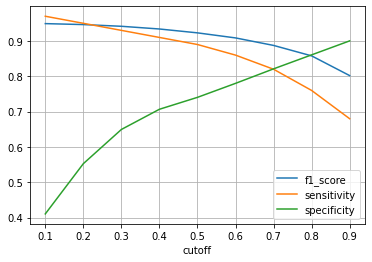

In [106]:

# Let's plot accuracy sensitivity and specificity for various probabilities.
cut_off_df.plot.line(x='cutoff', y=['f1_score','sensitivity','specificity'])
plt.grid()
plt.show()

- we can see that we are getting balance of sensitivity and specificity at cutoff 0.7 
- so we will use cutoff =0.7 instead of 0.5 for final predictions in below class

In [108]:
import pickle


# Save to file in the current working directory
pkl_filename = "logisticReg_final_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(lm, file)

In [109]:
# Load from file

with open('logisticReg_final_model.pkl', 'rb') as file:
    model = pickle.load(file)

In [110]:
with open('tf_idf_vectorizer_new.pkl', 'rb') as file:
    tf1 = pickle.load(file)

In [151]:
create_vectore= tf1.transform(['I am Data science enthusiast'])

create_vectore.shape

(1, 5000)

- We can see that we have got 5000 size vector for above text 

# Create class for predicting snetiment using above model

In [135]:
import re # for regular expressions
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from spellchecker import SpellChecker
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import pickle

words_removed= ['collect', 'part', 'promote', 'review', 'really', 'product']

stemmer = PorterStemmer()

spell = SpellChecker()

with open('logisticReg_final_model.pkl', 'rb') as file:
    model = pickle.load(file)
    
with open('tf_idf_vectorizer_new.pkl', 'rb') as file:
    tf_idf = pickle.load(file)
    

class get_sentiment():
    
    def __init__(self):
        
        return None
    
    def clean_review(self, review_text):
        review_text = re.sub(r"http\S+|www.\S+", "", review_text)                         ## remove the urls
        review_text = re.sub("[^a-zA-Z]", " ", review_text)                       ## remove numbers and puncuation
        review_text = str(review_text).lower()                                    ## converting into lower case
        review_text = word_tokenize(review_text)                                  ## tokenization
        review_text = [i for i in review_text if len(i)>2]                        ## remove the words having length less than 2
        review_text = [i for i in review_text if i not in stopwords.words('english')]  ## remove stop words
        review_text = [stemmer.stem(i) for i in review_text]                           ## stemming 
        review_text = [spell.correction(i) for i in review_text]                       ## spell correction
        review_text = [i for i in review_text if i not in words_removed]
        review_text = ' '.join(review_text)
        
        return(review_text)
    
    def sentiment (self, review_text):
        
        review_text = self.clean_review(review_text)
        
        X = tf_idf.transform([review_text])
        
        pred_proba= model.predict_proba(X)[:,1]
        y = 1 if pred_proba[0] > 0.7 else 0
        
        return(int(y))

In [145]:
sentiment_obj= get_sentiment()

In [147]:

review_text = "i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the "

print(review)

i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the 


In [148]:
sentiment_obj.clean_review(review_text)

'love album good hip hop side current pop sound hype listen everyday'

In [149]:
sentiment_obj.sentiment(review_text)

1

 - We got the positive (1) snetiment for above movie
 - for part 2 we will create recommendation engine and then integrate it with above snetiment analysis model